###**Deep Learning Assignment-4 : Iris Flower Classification using Neural Network**

**Name:** Yesha Pandya

**Enrolment Number:** 23BT04175

**Div:** 1 **Batch:** C

**Objective:**

Design a NN for Iris Dataset and write the answers in a comprehensive manner:
1. Write the combination of:
    * No of layers
    * Activation functions at each layer
    * Optimizer used
to calculate the best accuracy and lowest cost.
2. Also calculate the variance of the solutions calculated
3. Draw the chart showing the training data accuracy and testing data accuracy
4. Draw the chart to compare the training data loss and testing data loss.
5. Take a sample input value from the dataset and find the predicted value and compare the result with actual value

In [2]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

#set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

#load the dataset
try:
    df = pd.read_csv('Iris.csv')
except FileNotFoundError:
    print("Error: File not found. Please upload 'Iris - Iris.csv'")

#display dataset info
print("Dataset Head:")
print(df.head())

Dataset Head:
   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa


**Data Preprocessing**

We need to prepare the data for the neural network:
* Feature Extraction: Separate the input features (X) from the target labels (y)
* Encoding: Convert the text labels (e.g., 'Iris-setosa') into numerical values using `LabelEncoder`, and then into a One-Hot Encoded format (e.g., [1, 0, 0]) using `to_categorical`.

In [3]:
#separate Features (X) and Target (y)
X = df.drop(['Id', 'Species'], axis=1).values
y = df['Species'].values

#encode string labels to integers (0, 1, 2)
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

#convert integers to One-Hot encoded vectors
y_dummy = to_categorical(y_encoded)

print(f"Original Label: {y[0]}")
print(f"Encoded Label: {y_encoded[0]}")
print(f"One-Hot Label: {y_dummy[0]}")

Original Label: Iris-setosa
Encoded Label: 0
One-Hot Label: [1. 0. 0.]


In [4]:
#train-test-split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y_dummy, test_size=0.2, random_state=42)

print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")

Training Shape: (120, 4)
Testing Shape: (30, 4)


**Define Model Building Function**

To answer Question 1, we need to try different combinations. We define a function `build_model` that allows us to create neural networks with variable numbers of layers, neurons, activation functions, and optimizers.

In [5]:
def build_model(num_hidden_layers, neurons, activation, optimizer_name):
    model = Sequential()

    #input Layer + first hidden layer
    model.add(Dense(neurons, input_shape=(4,), activation=activation))

    # Additional Hidden Layers
    for _ in range(num_hidden_layers - 1):
        model.add(Dense(neurons, activation=activation))

    # Output Layer (3 classes -> Softmax activation)
    model.add(Dense(3, activation='softmax'))

    #select optimizer
    if optimizer_name == 'Adam':
        opt = Adam(learning_rate=0.01)
    else:
        opt = SGD(learning_rate=0.01)

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

**Find Best Hyperparameters**

We perform a `Grid Search` by looping through different configurations. We track the validation accuracy for each to find the best combination.
* Layers: Testing 1 vs 2 hidden layers
* Activation: ReLU vs Tanh
* Optimizer: Adam vs SGD

In [7]:
#define configurations to test
configs = [
    {'layers': 1, 'nodes': 10, 'act': 'relu', 'opt': 'SGD'},
    {'layers': 1, 'nodes': 10, 'act': 'relu', 'opt': 'Adam'},
    {'layers': 2, 'nodes': 16, 'act': 'relu', 'opt': 'Adam'},
    {'layers': 2, 'nodes': 16, 'act': 'tanh', 'opt': 'Adam'}
]

best_acc = 0
best_config = None

print("Searching for best configuration...")
for config in configs:
    #build
    model = build_model(config['layers'], config['nodes'], config['act'], config['opt'])
    #train
    history = model.fit(X_train, y_train, epochs=30, verbose=0, validation_data=(X_test, y_test))
    #evaluate
    val_acc = history.history['val_accuracy'][-1]

    print(f"Config: {config} -> Val Acc: {val_acc:.4f}")

    if val_acc >= best_acc:
        best_acc = val_acc
        best_config = config

print("\n")
print(f"BEST CONFIGURATION FOUND:\n {best_config}")
print("\n")

Searching for best configuration...
Config: {'layers': 1, 'nodes': 10, 'act': 'relu', 'opt': 'SGD'} -> Val Acc: 0.8000
Config: {'layers': 1, 'nodes': 10, 'act': 'relu', 'opt': 'Adam'} -> Val Acc: 1.0000
Config: {'layers': 2, 'nodes': 16, 'act': 'relu', 'opt': 'Adam'} -> Val Acc: 0.9667
Config: {'layers': 2, 'nodes': 16, 'act': 'tanh', 'opt': 'Adam'} -> Val Acc: 1.0000


BEST CONFIGURATION FOUND:
 {'layers': 2, 'nodes': 16, 'act': 'tanh', 'opt': 'Adam'}




**Calculate Variance**

Now that we have the best configuration, we train it multiple times (5 runs) to calculate the Variance. This tells us how stable the model is. If the variance is low, the model is reliable.

In [8]:
accuracies = []

print("Calculating Variance (Running 5 times)...")
for i in range(5):
    model = build_model(best_config['layers'], best_config['nodes'], best_config['act'], best_config['opt'])
    history = model.fit(X_train, y_train, epochs=40, verbose=0, validation_data=(X_test, y_test))
    acc = history.history['val_accuracy'][-1]
    accuracies.append(acc)
    print(f"Run {i+1}: {acc:.4f}")

variance = np.var(accuracies)
mean_acc = np.mean(accuracies)

print(f"\nMean Accuracy: {mean_acc:.4f}")
print(f"Variance: {variance:.6f}")

Calculating Variance (Running 5 times)...
Run 1: 1.0000
Run 2: 1.0000
Run 3: 1.0000
Run 4: 1.0000
Run 5: 1.0000

Mean Accuracy: 1.0000
Variance: 0.000000


**Train Final Model for Plotting**

We train the model one last time with more epochs (100) to capture the full learning curve for our charts.

In [9]:
#build final model using best config
final_model = build_model(best_config['layers'], best_config['nodes'], best_config['act'], best_config['opt'])

#train for 100 epochs
history = final_model.fit(X_train, y_train, epochs=100, verbose=0, validation_data=(X_test, y_test))

print("Final Training Complete.")

Final Training Complete.


**Accuracy and Loss Charts**

We plot the Training vs. Testing Accuracy and Training vs. Testing Loss to analyze the model's performance visually.

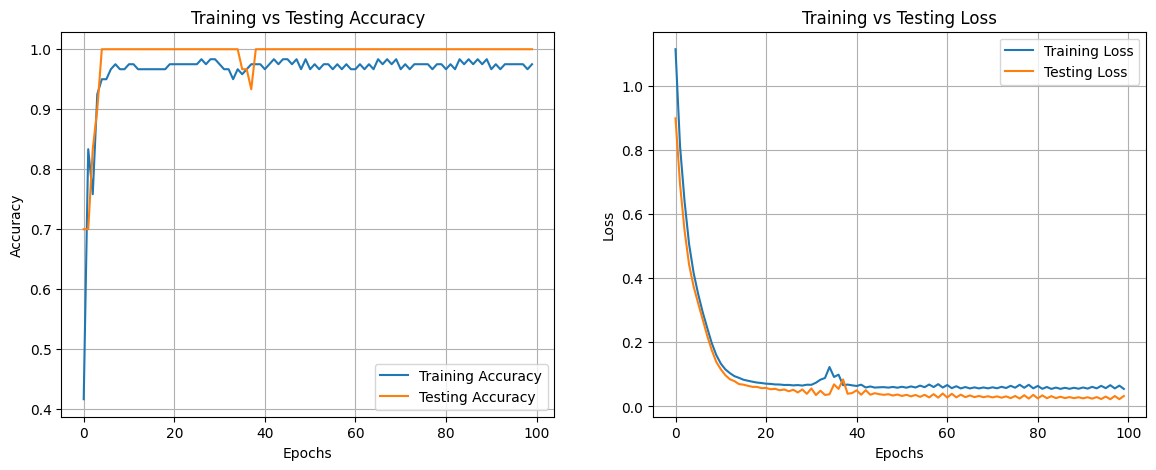

In [10]:
plt.figure(figsize=(14, 5))

#plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.title('Training vs Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

#plot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.title('Training vs Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

**Sample Prediction**

Finally, we pick a random sample from the test set, predict its species using our trained model and compare it with the actual species to verify correctness.

In [11]:
#pick a random sample index
idx = np.random.randint(0, len(X_test))

#get the sample data and actual label
sample_input = X_test[idx].reshape(1, -1)
actual_label_encoded = np.argmax(y_test[idx])
actual_species = encoder.inverse_transform([actual_label_encoded])[0]

#predict
prediction = final_model.predict(sample_input)
predicted_label_encoded = np.argmax(prediction)
predicted_species = encoder.inverse_transform([predicted_label_encoded])[0]

#display results
print("-" * 30)
print(f"Sample Input Features: {sample_input[0]}")
print(f"Predicted Species:   {predicted_species}")
print(f"Actual Species:      {actual_species}")
print("-" * 30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
------------------------------
Sample Input Features: [5.6 2.9 3.6 1.3]
Predicted Species:   Iris-versicolor
Actual Species:      Iris-versicolor
------------------------------
